# Содержание

Описание проекта:

Заказчик этого исследования — сеть отелей «Как в гостях».
Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.


Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

In [ ]:
!pip3 install category_encoders
!pip3 install pandas_profiling
!pip3 install optuna

     |████████████████████████████████| 72 kB 252 kB/s eta 0:00:01
     |████████████████████████████████| 268 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 10.9 MB/s eta 0:00:01
     |████████████████████████████████| 709 kB 86.4 MB/s eta 0:00:01
     |████████████████████████████████| 102 kB 91.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 92.5 MB/s eta 0:00:01
     |████████████████████████████████| 296 kB 63.1 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 76.2 MB/s eta 0:00:01
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27085 sha256=2569521c4e555253443a9a35a05e473f3ec350a823e4dc01ccaabb7f7b242a3c
  Stored in directory: /home/jovyan/.cache/pip/wheels/1d/05/04/c6d7d3b66539d9e659ac6dfe81e2d0fd4c1a8316cc5a403300
Successfully built htmlmin
     |████████████████████████████████| 348 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 42.2 MB 29 kB/s s eta 0:00:01
     |█████████████

In [ ]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
import optuna
from sklearn.metrics import classification_report,balanced_accuracy_score, accuracy_score, f1_score, precision_score,recall_score, fbeta_score,roc_auc_score
import warnings
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_roc_curve,plot_confusion_matrix
from category_encoders.binary import BinaryEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle





In [ ]:
# скрываем предупреждения
warnings.filterwarnings('ignore')

In [ ]:
try:
    hotel_train = pd.read_csv(r'C:\Users\new\Downloads\hotel_train.csv')
    hotel_test = pd.read_csv(r'C:\Users\new\Downloads\hotel_test.csv')

except:
    hotel_train = pd.read_csv(r'/datasets/hotel_train.csv')
    hotel_test = pd.read_csv(r'/datasets/hotel_test.csv')

## Предосмотр данных

In [ ]:
# Функция для ознакомления с данными
def pre_view(data,n_row=4,
             head=True,
             info=True,
             columns=True,
             shape=True,
             isna=True,
             duplicated=True,
             dtypes_=True,
            describe_=True):
    if head:
        print(f'First {n_row} row(s) in the head of data')
        display(data.head(n_row))
        print('-'*30)
    if info:
        print('Data Information:')
        display(data.info())
        print('-'*30)
    if columns:
        print('Data columns:')
        display(data.columns)
        print('-'*30)
    if shape:
        print('Data shape:')
        display(data.shape)
        print('-'*30)
    if isna:
        print('Data isna by row mean:')
        display(data.isna().mean())
        print('-'*30)
    if duplicated:
        print('Data clear duplicates sum:')
        display(data.duplicated().sum())
        print('-'*30)
    if dtypes_:
        print('Data dtypes:')
        display(data.dtypes)
        print('Number of each type:')
        print(counter_of_type(data))
        print('-'*30)
    if describe_:
        print('Major statistics for data:')
        display(data.describe())


In [ ]:
def counter_of_type(data):
    return Counter(data.dtypes)


In [ ]:
hotel_train.dtypes

id                                  int64
is_canceled                         int64
lead_time                         float64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                            float64
children                          float64
babies                            float64
meal                               object
country                            object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
booking_changes                     int64
days_in_waiting_list                int64
customer_type                      object
required_car_parking_spaces         int64
total_of_special_requests         

In [ ]:
pre_view(hotel_train)

First 4 row(s) in the head of data


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2


------------------------------
Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-nu

None

------------------------------
Data columns:


Index(['id', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'days_in_waiting_list',
       'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights'],
      dtype='object')

------------------------------
Data shape:


(65229, 25)

------------------------------
Data isna by row mean:


id                                0.0
is_canceled                       0.0
lead_time                         0.0
arrival_date_year                 0.0
arrival_date_month                0.0
arrival_date_week_number          0.0
arrival_date_day_of_month         0.0
stays_in_weekend_nights           0.0
stays_in_week_nights              0.0
adults                            0.0
children                          0.0
babies                            0.0
meal                              0.0
country                           0.0
distribution_channel              0.0
is_repeated_guest                 0.0
previous_cancellations            0.0
previous_bookings_not_canceled    0.0
reserved_room_type                0.0
booking_changes                   0.0
days_in_waiting_list              0.0
customer_type                     0.0
required_car_parking_spaces       0.0
total_of_special_requests         0.0
total_nights                      0.0
dtype: float64

------------------------------
Data clear duplicates sum:


0

------------------------------
Data dtypes:


id                                  int64
is_canceled                         int64
lead_time                         float64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                            float64
children                          float64
babies                            float64
meal                               object
country                            object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
booking_changes                     int64
days_in_waiting_list                int64
customer_type                      object
required_car_parking_spaces         int64
total_of_special_requests         

Number of each type:
Counter({dtype('int64'): 15, dtype('O'): 6, dtype('float64'): 4})
------------------------------
Major statistics for data:


,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


In [ ]:
hotel_train['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [ ]:
hotel_train['babies'].value_counts()

0.0     64777
1.0       447
2.0         3
9.0         1
10.0        1
Name: babies, dtype: int64

In [ ]:
hotel_train[hotel_train['babies'] == 10].T

,22995
id,30935
is_canceled,0
lead_time,37.0
arrival_date_year,2016
arrival_date_month,January
arrival_date_week_number,3
arrival_date_day_of_month,12
stays_in_weekend_nights,0
stays_in_week_nights,2
adults,2.0


In [ ]:
hotel_train[hotel_train['babies'] == 9].T

,41528
id,59925
is_canceled,0
lead_time,11.0
arrival_date_year,2015
arrival_date_month,October
arrival_date_week_number,42
arrival_date_day_of_month,11
stays_in_weekend_nights,2
stays_in_week_nights,1
adults,1.0


In [ ]:
hotel_train['days_in_waiting_list'].value_counts()

0      62005
39       185
58       164
44       137
31       126
       ...  
89         1
76         1
13         1
142        1
14         1
Name: days_in_waiting_list, Length: 97, dtype: int64

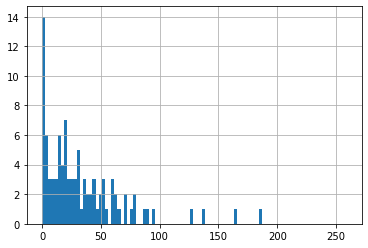

In [ ]:
hotel_train['days_in_waiting_list'].value_counts().hist(bins=hotel_train['days_in_waiting_list'].nunique(),
                                                        range=[0,hotel_train['days_in_waiting_list'].max()],
                                                        grid=True)
plt.show()

In [ ]:
hotel_train['booking_changes'].value_counts()

0     56195
1      6615
2      1754
3       413
4       149
5        42
6        19
7        18
8         7
9         5
13        4
10        2
14        2
15        2
16        1
17        1
Name: booking_changes, dtype: int64

In [ ]:
hotel_train[hotel_train['booking_changes'] > 7].sort_values(by='lead_time')

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
22718,30658,1,22.0,2015,December,53,29,0,5,2.0,...,0,0,0,F,8,0,Transient,0,0,5
64035,82750,0,28.0,2016,December,49,1,1,3,1.0,...,0,0,0,A,14,0,Transient-Party,0,1,4
26624,34564,1,60.0,2016,April,18,30,1,1,1.0,...,0,0,0,A,9,0,Transient,0,0,2
58142,76800,0,64.0,2016,September,36,1,2,5,2.0,...,0,0,0,A,10,0,Transient,0,3,7
12210,14840,0,78.0,2016,April,18,29,2,5,1.0,...,0,0,0,A,8,0,Transient-Party,0,0,7
12009,14627,0,101.0,2016,April,18,29,2,5,2.0,...,0,0,0,A,9,0,Transient-Party,0,0,7
12166,14791,0,101.0,2016,April,18,29,2,3,2.0,...,0,0,0,A,13,0,Transient-Party,0,1,5
12212,14842,0,101.0,2016,April,18,29,2,5,1.0,...,0,0,0,A,9,0,Transient-Party,0,0,7
57526,76164,0,134.0,2016,August,34,19,2,2,2.0,...,0,0,0,D,8,0,Transient,0,2,4
61657,80348,0,153.0,2016,October,43,17,2,5,3.0,...,0,0,0,D,8,0,Transient,0,3,7


In [ ]:
# ProfileReport(hotel_train)

In [ ]:
def cat_counter(data,cat='object'):
    cat_lst = []
    tmp_cat = data.dtypes.reset_index()
    tmp_cat.columns = ['name','type']
    filtered_by_type = tmp_cat.loc[tmp_cat['type'] == cat]
    cat_lst = list(np.array(filtered_by_type['name']))
    for i in cat_lst:
        print(f'In the column {i} the nubmer of unique value is {data[i].nunique()} and the list of the unique value is {data[i].unique()}\n')


In [ ]:
cat_counter(hotel_test)

In the column arrival_date_month the nubmer of unique value is 8 and the list of the unique value is ['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']

In the column meal the nubmer of unique value is 5 and the list of the unique value is ['BB       ' 'HB       ' 'SC' 'FB       ' 'SC       ']

In the column country the nubmer of unique value is 143 and the list of the unique value is ['PRT' 'AUT' 'BEL' 'DEU' 'BRA' 'GBR' 'ESP' 'FRA' 'ITA' 'LUX' 'CHE' 'EST'
 'NGA' 'IRL' 'CN' 'POL' 'AUS' 'NLD' 'KOR' 'ROU' 'USA' 'CHL' 'DNK' 'FIN'
 'RUS' 'SWE' 'HUN' 'HRV' 'MDV' 'ZAF' 'ISR' 'NOR' 'CHN' 'ARE' 'MAR' 'COL'
 'FJI' 'LVA' 'LBN' 'PHL' 'HKG' 'SYC' 'GIB' 'AGO' 'MYS' 'MDG' 'IDN' 'LTU'
 'ISL' 'TUR' 'ARG' 'JPN' 'SVN' 'SVK' 'BGR' 'CAF' 'JAM' 'UZB' 'UKR' 'IND'
 'CZE' 'URY' 'NZL' 'NPL' 'SRB' 'CPV' 'IRN' 'KAZ' 'BHS' 'SUR' 'CUB' 'PAK'
 'MAC' 'CYP' 'JOR' 'GRC' 'KWT' 'TWN' 'VNM' 'SGP' 'DOM' 'VEN' 'SEN' 'BLR'
 'TZA' 'LIE' 'GNB' 'SAU' 'DZA' 'PER' 'AZE' 'EGY' 'ETH' 'KEN' 'THA' 'MLT'
 'ECU' 'AND'

In [ ]:
def string_stripper(data,column):
    data[column] = data[column].str.strip()

In [ ]:
object_to_strip = ['reserved_room_type','meal']

In [ ]:
string_stripper(hotel_train,'reserved_room_type')

In [ ]:
hotel_train['reserved_room_type'].unique()

array(['A', 'C', 'D', 'E', 'G', 'F', 'B'], dtype=object)

In [ ]:
string_stripper(hotel_train,'meal')

In [ ]:
hotel_train['meal'].unique()

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

### Вывод по hotel_train.

1.Убрали пробелы в значениях в столбцах

2. `babies`:

* Считаю, что `10` - аномалия и это очепатка, кто просто внес нечайно вместо `1` `10` - случайно нажали на ноль.
* Значение  `9` является аномальным и также ялвяется очепаткой - человек вместо `0` нажал `9`, будет правильнее, если мы сохраним и отредактируем эту запись.

3. `booking_changes`

* Считаю, что тут аномальных значений нет, потому что `lead_time` достаточно большое, и за это время можно сто раз что-то поменять и т.п. Так что оставим как есть.

4. `days_in_waiting_list`

* В этой колонке, несмотря на большие значения, нет аномалий. Сохраняем все как есть.

5. Все остальные колоны выглядят более или менее адекватно.


Преобразования столбцов и данных:

* `lead_time` to int (astype)
* `arrival_date_month` to int with replace
* `adults` to int (astype)
* `children` to int (astype)
* `babies` to int (astype)
* `meal` to int replace
* `country` to matrix {1,0} to BinaryEncoding
* `distribution_channel` to int with replace
* `reserved_room_type` to int with replace
* `customer_type` to int with replace

In [ ]:
hotel_test.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


In [ ]:
pre_view(hotel_test)

First 4 row(s) in the head of data


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4


------------------------------
Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-nu

None

------------------------------
Data columns:


Index(['id', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'days_in_waiting_list',
       'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights'],
      dtype='object')

------------------------------
Data shape:


(32412, 25)

------------------------------
Data isna by row mean:


id                                0.0
is_canceled                       0.0
lead_time                         0.0
arrival_date_year                 0.0
arrival_date_month                0.0
arrival_date_week_number          0.0
arrival_date_day_of_month         0.0
stays_in_weekend_nights           0.0
stays_in_week_nights              0.0
adults                            0.0
children                          0.0
babies                            0.0
meal                              0.0
country                           0.0
distribution_channel              0.0
is_repeated_guest                 0.0
previous_cancellations            0.0
previous_bookings_not_canceled    0.0
reserved_room_type                0.0
booking_changes                   0.0
days_in_waiting_list              0.0
customer_type                     0.0
required_car_parking_spaces       0.0
total_of_special_requests         0.0
total_nights                      0.0
dtype: float64

------------------------------
Data clear duplicates sum:


0

------------------------------
Data dtypes:


id                                  int64
is_canceled                         int64
lead_time                         float64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                            float64
children                          float64
babies                            float64
meal                               object
country                            object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
booking_changes                     int64
days_in_waiting_list                int64
customer_type                      object
required_car_parking_spaces         int64
total_of_special_requests         

Number of each type:
Counter({dtype('int64'): 15, dtype('O'): 6, dtype('float64'): 4})
------------------------------
Major statistics for data:


,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


In [ ]:
cat_counter(hotel_test)

In the column arrival_date_month the nubmer of unique value is 8 and the list of the unique value is ['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']

In the column meal the nubmer of unique value is 5 and the list of the unique value is ['BB       ' 'HB       ' 'SC' 'FB       ' 'SC       ']

In the column country the nubmer of unique value is 143 and the list of the unique value is ['PRT' 'AUT' 'BEL' 'DEU' 'BRA' 'GBR' 'ESP' 'FRA' 'ITA' 'LUX' 'CHE' 'EST'
 'NGA' 'IRL' 'CN' 'POL' 'AUS' 'NLD' 'KOR' 'ROU' 'USA' 'CHL' 'DNK' 'FIN'
 'RUS' 'SWE' 'HUN' 'HRV' 'MDV' 'ZAF' 'ISR' 'NOR' 'CHN' 'ARE' 'MAR' 'COL'
 'FJI' 'LVA' 'LBN' 'PHL' 'HKG' 'SYC' 'GIB' 'AGO' 'MYS' 'MDG' 'IDN' 'LTU'
 'ISL' 'TUR' 'ARG' 'JPN' 'SVN' 'SVK' 'BGR' 'CAF' 'JAM' 'UZB' 'UKR' 'IND'
 'CZE' 'URY' 'NZL' 'NPL' 'SRB' 'CPV' 'IRN' 'KAZ' 'BHS' 'SUR' 'CUB' 'PAK'
 'MAC' 'CYP' 'JOR' 'GRC' 'KWT' 'TWN' 'VNM' 'SGP' 'DOM' 'VEN' 'SEN' 'BLR'
 'TZA' 'LIE' 'GNB' 'SAU' 'DZA' 'PER' 'AZE' 'EGY' 'ETH' 'KEN' 'THA' 'MLT'
 'ECU' 'AND'

In [ ]:
string_stripper(hotel_test,'reserved_room_type')

In [ ]:
hotel_test['reserved_room_type'].unique()

array(['A', 'E', 'G', 'D', 'F', 'C', 'B'], dtype=object)

In [ ]:
string_stripper(hotel_test,'meal')

In [ ]:
hotel_test['meal'].unique()

array(['BB', 'HB', 'SC', 'FB'], dtype=object)

In [ ]:
hotel_test[hotel_test['required_car_parking_spaces'] > 1]

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
2502,15629,0,5.0,2017,March,10,10,0,2,2.0,...,1,0,0,G,1,0,Transient,2,2,2
2549,17717,0,26.0,2017,March,11,14,0,5,2.0,...,1,0,2,E,1,0,Transient-Party,8,1,5
2550,17718,0,138.0,2017,March,12,19,2,2,2.0,...,1,0,2,E,1,122,Transient-Party,8,0,4
2813,19725,0,7.0,2017,January,2,11,0,2,2.0,...,0,0,0,A,0,0,Transient,2,1,2
3247,20164,0,0.0,2017,January,4,27,0,2,2.0,...,0,0,0,G,0,0,Transient-Party,2,0,2
3248,20165,0,0.0,2017,January,5,29,1,0,2.0,...,1,0,0,G,0,0,Transient-Party,2,0,1
3277,20195,0,43.0,2017,January,4,27,1,2,2.0,...,0,0,0,A,0,0,Transient-Party,2,1,3
4197,21132,0,5.0,2017,February,9,28,1,5,2.0,...,0,0,0,A,1,0,Transient-Party,2,0,6
25031,90523,0,30.0,2017,April,17,29,2,1,2.0,...,0,0,0,A,0,0,Transient-Party,3,2,3


In [ ]:
# ProfileReport(hotel_test)

### Вывод по hotel_test.


1. Убрали пробелы в значениях в столбцах

2. `required_car_parking_spaces`

* В этой колонке, несмотря на большие значения, нет аномалий. Сохраняем все как есть. Возможно действительно человеку нужно было 8 машин, кто его знает...

3. Все остальные колоны выглядят более или менее адекватно.


Преобразования столбцов и данных:

* `lead_time` to int (astype)
* `arrival_date_month` to int with replace
* `adults` to int (astype)
* `children` to int (astype)
* `babies` to int (astype)
* `meal` to int replace
* `country` to matrix {1,0} to BinaryEncoding
* `distribution_channel` to int with replace
* `reserved_room_type` to int with replace
* `customer_type` to int with replace

## Ретушь hotel_train

In [ ]:
hotel_train.loc[hotel_train['babies'] == 10]

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
22995,30935,0,37.0,2016,January,3,12,0,2,2.0,...,0,0,0,D,1,0,Transient,0,1,2


In [ ]:
hotel_train.loc[hotel_train['babies'] == 10,'babies'] = 1

In [ ]:
hotel_train.loc[hotel_train['babies'] == 10]

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights


In [ ]:
hotel_train.loc[hotel_train['babies'] == 9]

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
41528,59925,0,11.0,2015,October,42,11,2,1,1.0,...,0,0,0,A,1,0,Transient-Party,0,0,3


In [ ]:
hotel_train.loc[hotel_train['babies'] == 9,'babies'] =0

In [ ]:
hotel_train.loc[hotel_train['babies'] == 9]

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights


In [ ]:
to_int_lst_train = ['lead_time','adults','children','babies']

In [ ]:
hotel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [ ]:
def to_int_train(col):
    hotel_train[col] = hotel_train[col].astype('int64',errors='raise')

In [ ]:
list(map(to_int_train,to_int_lst_train))

[None, None, None, None]

In [ ]:
hotel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              65229 non-null  int64 
 1   is_canceled                     65229 non-null  int64 
 2   lead_time                       65229 non-null  int64 
 3   arrival_date_year               65229 non-null  int64 
 4   arrival_date_month              65229 non-null  object
 5   arrival_date_week_number        65229 non-null  int64 
 6   arrival_date_day_of_month       65229 non-null  int64 
 7   stays_in_weekend_nights         65229 non-null  int64 
 8   stays_in_week_nights            65229 non-null  int64 
 9   adults                          65229 non-null  int64 
 10  children                        65229 non-null  int64 
 11  babies                          65229 non-null  int64 
 12  meal                            65229 non-null

In [ ]:
def value_replace(data,column,dct,check=True):
    if check:
        print('Before replacement the unique values are:')
        print(data[column].unique())
        print('-'*30)
    data[column] = data[column].replace(to_replace=dct)
    if check:
        print('After replacement the unique values are:')
        print(data[column].unique())

In [ ]:
hotel_train['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [ ]:
months_dct_train = {'January':0,'February':1,'March':2,'April':3,'May':4,'June':5,'July':6,'August':7,'September':8,'October':9,'November':10,'December':11}

In [ ]:
value_replace(data=hotel_train,column='arrival_date_month',dct=months_dct_train)

Before replacement the unique values are:
['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
------------------------------
After replacement the unique values are:
[ 6  7  8  9 10 11  0  1  2  3  4  5]


In [ ]:
hotel_train['meal'].unique()

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

In [ ]:
meal_dct_train = {'BB':0,'FB':1,'HB':2,'SC':3}

In [ ]:
value_replace(data=hotel_train,column='meal',dct=meal_dct_train)

Before replacement the unique values are:
['BB' 'FB' 'HB' 'SC']
------------------------------
After replacement the unique values are:
[0 1 2 3]


In [ ]:
bn = BinaryEncoder(cols='country')

In [ ]:
bn.fit(hotel_train)

BinaryEncoder(cols=['country'],
              mapping=[{'col': 'country',
                        'mapping':       country_0  country_1  country_2  country_3  country_4  country_5  \
 1            0          0          0          0          0          0   
 2            0          0          0          0          0          0   
 3            0          0          0          0          0          0   
 4            0          0          0          0          0          1   
 5            0          0          0          0          0          1   
...         ...        ...        ...        ...        ...        ...   
 153          1          0          0          1          1          0   
 154          1          0          0          1          1          0   
 155          1          0          0          1          1          0   
-1            0          0          0          0          0          0   
-2            0          0          0          0          0          0   

  

In [ ]:
hotel_train = bn.fit_transform(hotel_train)

In [ ]:
hotel_train.columns

Index(['id', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country_0', 'country_1', 'country_2', 'country_3', 'country_4',
       'country_5', 'country_6', 'country_7', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'days_in_waiting_list', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_nights'],
      dtype='object')

In [ ]:
hotel_train['distribution_channel'].unique()

array(['Direct', 'TA/TO', 'Corporate', 'GDS'], dtype=object)

In [ ]:
def auto_dct(unique_values,ordinal=False,reverse_=False):
    tmp_dct = dict()
    if ordinal == 0:
        for i in range(len(unique_values)):
            tmp_dct[unique_values[i]] = i
    else:
        for i in range(len(unique_values)):
            tmp_dct[sorted(unique_values,reverse=reverse_)[i]] = i
    return tmp_dct

In [ ]:
distribution_channel_dct_train = auto_dct(hotel_train['distribution_channel'].unique())

In [ ]:
distribution_channel_dct_train

{'Direct': 0, 'TA/TO': 1, 'Corporate': 2, 'GDS': 3}

In [ ]:
value_replace(data=hotel_train,column='distribution_channel',dct=distribution_channel_dct_train)

Before replacement the unique values are:
['Direct' 'TA/TO' 'Corporate' 'GDS']
------------------------------
After replacement the unique values are:
[0 1 2 3]


In [ ]:
reserved_room_type_train = auto_dct(hotel_train['reserved_room_type'].unique(),ordinal=True,reverse_=True)

In [ ]:
reserved_room_type_train

{'G': 0, 'F': 1, 'E': 2, 'D': 3, 'C': 4, 'B': 5, 'A': 6}

In [ ]:
value_replace(data=hotel_train,column='reserved_room_type',dct=reserved_room_type_train)

Before replacement the unique values are:
['A' 'C' 'D' 'E' 'G' 'F' 'B']
------------------------------
After replacement the unique values are:
[6 4 3 2 0 1 5]


In [ ]:
customer_type_train = auto_dct(hotel_train['customer_type'].unique())

In [ ]:
customer_type_train

{'Transient': 0, 'Contract': 1, 'Transient-Party': 2, 'Group': 3}

In [ ]:
value_replace(data=hotel_train,column='customer_type',dct=customer_type_train)

Before replacement the unique values are:
['Transient' 'Contract' 'Transient-Party' 'Group']
------------------------------
After replacement the unique values are:
[0 1 2 3]


In [ ]:
hotel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   id                              65229 non-null  int64
 1   is_canceled                     65229 non-null  int64
 2   lead_time                       65229 non-null  int64
 3   arrival_date_year               65229 non-null  int64
 4   arrival_date_month              65229 non-null  int64
 5   arrival_date_week_number        65229 non-null  int64
 6   arrival_date_day_of_month       65229 non-null  int64
 7   stays_in_weekend_nights         65229 non-null  int64
 8   stays_in_week_nights            65229 non-null  int64
 9   adults                          65229 non-null  int64
 10  children                        65229 non-null  int64
 11  babies                          65229 non-null  int64
 12  meal                            65229 non-null  int64
 13  c

## Ретушь hotel_test

In [ ]:
hotel_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

In [ ]:
to_int_lst_test = ['lead_time','adults','children','babies']

In [ ]:
def to_int_test(col):
    hotel_test[col] = hotel_test[col].astype('int')

In [ ]:
list(map(to_int_test,to_int_lst_test))

[None, None, None, None]

In [ ]:
hotel_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              32412 non-null  int64 
 1   is_canceled                     32412 non-null  int64 
 2   lead_time                       32412 non-null  int64 
 3   arrival_date_year               32412 non-null  int64 
 4   arrival_date_month              32412 non-null  object
 5   arrival_date_week_number        32412 non-null  int64 
 6   arrival_date_day_of_month       32412 non-null  int64 
 7   stays_in_weekend_nights         32412 non-null  int64 
 8   stays_in_week_nights            32412 non-null  int64 
 9   adults                          32412 non-null  int64 
 10  children                        32412 non-null  int64 
 11  babies                          32412 non-null  int64 
 12  meal                            32412 non-null

In [ ]:
hotel_test['arrival_date_month'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

In [ ]:
value_replace(data=hotel_test,column='arrival_date_month',dct=months_dct_train)

Before replacement the unique values are:
['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']
------------------------------
After replacement the unique values are:
[0 1 2 3 4 5 6 7]


In [ ]:
hotel_test['meal'].unique()

array(['BB', 'HB', 'SC', 'FB'], dtype=object)

In [ ]:
meal_dct_train = {'BB':0,'FB':1,'HB':2,'SC':3}

In [ ]:
value_replace(data=hotel_test,column='meal',dct=meal_dct_train)

Before replacement the unique values are:
['BB' 'HB' 'SC' 'FB']
------------------------------
After replacement the unique values are:
[0 2 3 1]


In [ ]:
hotel_test = bn.transform(hotel_test)

In [ ]:
hotel_test.columns

Index(['id', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country_0', 'country_1', 'country_2', 'country_3', 'country_4',
       'country_5', 'country_6', 'country_7', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'days_in_waiting_list', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_nights'],
      dtype='object')

In [ ]:
value_replace(data=hotel_test,column='distribution_channel',dct=distribution_channel_dct_train)

Before replacement the unique values are:
['TA/TO' 'Direct' 'Corporate' 'GDS']
------------------------------
After replacement the unique values are:
[1 0 2 3]


In [ ]:
value_replace(data=hotel_test,column='reserved_room_type',dct=reserved_room_type_train)

Before replacement the unique values are:
['A' 'E' 'G' 'D' 'F' 'C' 'B']
------------------------------
After replacement the unique values are:
[6 2 0 3 1 4 5]


In [ ]:
value_replace(data=hotel_test,column='customer_type',dct=customer_type_train)

Before replacement the unique values are:
['Transient' 'Transient-Party' 'Contract' 'Group']
------------------------------
After replacement the unique values are:
[0 2 1 3]


In [ ]:
hotel_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   id                              32412 non-null  int64
 1   is_canceled                     32412 non-null  int64
 2   lead_time                       32412 non-null  int64
 3   arrival_date_year               32412 non-null  int64
 4   arrival_date_month              32412 non-null  int64
 5   arrival_date_week_number        32412 non-null  int64
 6   arrival_date_day_of_month       32412 non-null  int64
 7   stays_in_weekend_nights         32412 non-null  int64
 8   stays_in_week_nights            32412 non-null  int64
 9   adults                          32412 non-null  int64
 10  children                        32412 non-null  int64
 11  babies                          32412 non-null  int64
 12  meal                            32412 non-null  int64
 13  c

In [ ]:
reserved_room_type_train

{'G': 0, 'F': 1, 'E': 2, 'D': 3, 'C': 4, 'B': 5, 'A': 6}

In [ ]:
def add_new_columns(data):
    data['norm_room_cost'] = np.where(data['reserved_room_type'] == 0,350,
                                    np.where(data['reserved_room_type'] == 1,450,
                                    np.where(data['reserved_room_type'] == 2,500,
                                    np.where(data['reserved_room_type'] == 3,550,
                                    np.where(data['reserved_room_type'] == 4,600,
                                    np.where(data['reserved_room_type'] == 5,800,1000
                                            )
                                            )
                                            )
                                            )
                                            ))
    data['season_room_cost'] = np.where((((data['arrival_date_month'] >= 2) & (data['arrival_date_month']<=4)) |((data['arrival_date_month'] >=8) & (data['arrival_date_month']<=10))),data['norm_room_cost'] * 1.2,np.where(((data['arrival_date_month'] >=5) &(data['arrival_date_month'] <= 7)),data['norm_room_cost'] * 1.4,data['norm_room_cost']))
    data['number_of_cleaning'] = np.where(data['is_canceled'] != 1,2+(data['total_nights'] // 2),0)
    data['room_service_cost'] = np.where(data['reserved_room_type'] == 0,150,
                                    np.where(data['reserved_room_type'] == 1,150,
                                    np.where(data['reserved_room_type'] == 2,150,
                                    np.where(data['reserved_room_type'] == 3,150,
                                    np.where(data['reserved_room_type'] == 4,350,
                                    np.where(data['reserved_room_type'] == 5,350,400

                                            )
                                            )
                                            )
                                            )))

    print('Проверка:\n')
    print('Обычная стоимость номеров:')
    display(data['norm_room_cost'].unique())
    print('-'*50)
    print('Сезонные цены для обычного, весеннего и осеннего, летнего соответсвенно:')
    display(data[(data['arrival_date_month']== 1) & (data['norm_room_cost'] == 1000)]['season_room_cost'].head(1))
    display(data[(data['arrival_date_month']==3) & (data['norm_room_cost'] == 1000)]['season_room_cost'].head(1))
    display(data[(data['arrival_date_month']== 7) & (data['norm_room_cost'] == 1000)]['season_room_cost'].head(1))
    print('-'*50)
    print('\n Количество уборок:')
    print('Кол-во уборок у тех, кто не приехал:')
    print(data[data['is_canceled'] == 1]['number_of_cleaning'].sum())
    print('Кол-во уборок у тех, кто приехал:')
    print(data[data['is_canceled'] == 0]['number_of_cleaning'].sum())
    print('-'*50)
    print('Стоимость уборки:')
    print('Уникальные значения стоиости уборки:')
    print(data['room_service_cost'].unique())

In [ ]:
def total_revenue(data):
    data['total_revenue'] = np.where(data['is_canceled'] == 0,((data['season_room_cost'] * data['total_nights']) - (data['room_service_cost'] * data['number_of_cleaning'])),-(data['season_room_cost'] + data['room_service_cost']))

In [ ]:
add_new_columns(hotel_train)

Проверка:

Обычная стоимость номеров:


array([1000,  600,  550,  500,  350,  450,  800])

--------------------------------------------------
Сезонные цены для обычного, весеннего и осеннего, летнего соответсвенно:


2441    1000.0
Name: season_room_cost, dtype: float64

3094    1200.0
Name: season_room_cost, dtype: float64

522    1400.0
Name: season_room_cost, dtype: float64

--------------------------------------------------

 Количество уборок:
Кол-во уборок у тех, кто не приехал:
0
Кол-во уборок у тех, кто приехал:
133112
--------------------------------------------------
Стоимость уборки:
Уникальные значения стоиости уборки:
[400 350 150]


In [ ]:
hotel_train.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,norm_room_cost,season_room_cost,number_of_cleaning,room_service_cost
0,0,0,7,2015,6,27,1,0,1,1,...,0,0,0,0,0,1,1000,1400.0,2,400
1,1,0,14,2015,6,27,1,0,2,2,...,0,0,0,0,1,2,1000,1400.0,3,400
2,2,0,0,2015,6,27,1,0,2,2,...,0,0,0,0,0,2,600,840.0,3,350
3,3,0,9,2015,6,27,1,0,2,2,...,0,0,0,0,1,2,600,840.0,3,350
4,4,1,85,2015,6,27,1,0,3,2,...,0,0,0,0,1,3,1000,1400.0,0,400


In [ ]:
add_new_columns(hotel_test)

Проверка:

Обычная стоимость номеров:


array([1000,  500,  350,  550,  450,  600,  800])

--------------------------------------------------
Сезонные цены для обычного, весеннего и осеннего, летнего соответсвенно:


134    1000.0
Name: season_room_cost, dtype: float64

636    1200.0
Name: season_room_cost, dtype: float64

1955    1400.0
Name: season_room_cost, dtype: float64

--------------------------------------------------

 Количество уборок:
Кол-во уборок у тех, кто не приехал:
0
Кол-во уборок у тех, кто приехал:
65121
--------------------------------------------------
Стоимость уборки:
Уникальные значения стоиости уборки:
[400 150 350]


In [ ]:
hotel_train.head(1).T

,0
id,0.0
is_canceled,0.0
lead_time,7.0
arrival_date_year,2015.0
arrival_date_month,6.0
arrival_date_week_number,27.0
arrival_date_day_of_month,1.0
stays_in_weekend_nights,0.0
stays_in_week_nights,1.0
adults,1.0


In [ ]:
total_revenue(hotel_train)

In [ ]:

hotel_train.head(10)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,norm_room_cost,season_room_cost,number_of_cleaning,room_service_cost,total_revenue
0,0,0,7,2015,6,27,1,0,1,1,...,0,0,0,0,1,1000,1400.0,2,400,600.0
1,1,0,14,2015,6,27,1,0,2,2,...,0,0,0,1,2,1000,1400.0,3,400,1600.0
2,2,0,0,2015,6,27,1,0,2,2,...,0,0,0,0,2,600,840.0,3,350,630.0
3,3,0,9,2015,6,27,1,0,2,2,...,0,0,0,1,2,600,840.0,3,350,630.0
4,4,1,85,2015,6,27,1,0,3,2,...,0,0,0,1,3,1000,1400.0,0,400,-1800.0
5,5,1,75,2015,6,27,1,0,3,2,...,0,0,0,0,3,550,770.0,0,150,-920.0
6,6,1,23,2015,6,27,1,0,4,2,...,0,0,0,0,4,500,700.0,0,150,-850.0
7,7,0,18,2015,6,27,1,0,4,2,...,0,0,0,1,4,350,490.0,4,150,1360.0
8,8,0,68,2015,6,27,1,0,4,2,...,0,0,0,3,4,550,770.0,4,150,2480.0
9,9,0,37,2015,6,27,1,0,4,2,...,0,1,0,0,4,500,700.0,4,150,2200.0


In [ ]:
total_revenue(hotel_test)

In [ ]:
hotel_test[hotel_test['is_canceled'] == 0]

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,norm_room_cost,season_room_cost,number_of_cleaning,room_service_cost,total_revenue
95,6184,0,0,2017,0,4,25,0,1,1,...,0,0,0,0,1,1000,1000.0,2,400,200.0
299,6391,0,70,2017,1,8,22,0,4,2,...,0,2,0,0,4,1000,1000.0,4,400,2400.0
2041,8148,0,3,2017,7,33,17,0,1,1,...,0,0,0,0,1,1000,1400.0,2,400,600.0
2125,8232,0,7,2017,1,8,20,1,2,1,...,0,0,1,0,3,1000,1000.0,3,400,1800.0
2126,8236,0,6,2017,0,3,17,0,1,1,...,0,0,0,0,1,1000,1000.0,2,400,200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,97899,0,164,2017,7,35,31,2,4,2,...,0,0,0,0,6,1000,1400.0,5,400,6400.0
32408,97900,0,21,2017,7,35,30,2,5,2,...,0,0,0,2,7,1000,1400.0,5,400,7800.0
32409,97901,0,23,2017,7,35,30,2,5,2,...,0,0,0,0,7,1000,1400.0,5,400,7800.0
32410,97902,0,34,2017,7,35,31,2,5,2,...,0,0,0,4,7,550,770.0,5,150,4640.0


In [ ]:
def profit(data):
    return data['total_revenue'].sum()


In [ ]:
hotel_train_profit_wo_model = profit(hotel_train)

In [ ]:
hotel_train_profit_wo_model

52121070.0

In [ ]:
hotel_test_profit_wo_model = profit(hotel_test)

In [ ]:
hotel_test_profit_wo_model

26061570.0

In [ ]:
hotel_train['is_canceled'].value_counts()[0] / hotel_train['is_canceled'].value_counts()[1]

1.7129013475295292

In [ ]:
hotel_test['is_canceled'].value_counts()[0] / hotel_test['is_canceled'].value_counts()[1]

1.574219680724327

In [ ]:
class_weight = {0:1,1:1.6}

In [ ]:
rs = 7

In [ ]:
def feature_target(data):
    features = data.drop(columns=['is_canceled','id','arrival_date_year','lead_time','total_revenue','number_of_cleaning','norm_room_cost'],axis=1)
    target = data['is_canceled']
    return features,target

In [ ]:
hotel_train.head(1).T

,0
id,0.0
is_canceled,0.0
lead_time,7.0
arrival_date_year,2015.0
arrival_date_month,6.0
arrival_date_week_number,27.0
arrival_date_day_of_month,1.0
stays_in_weekend_nights,0.0
stays_in_week_nights,1.0
adults,1.0


In [ ]:
hotel_train[hotel_train['is_canceled'] == 1]

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,norm_room_cost,season_room_cost,number_of_cleaning,room_service_cost,total_revenue
4,4,1,85,2015,6,27,1,0,3,2,...,0,0,0,1,3,1000,1400.0,0,400,-1800.0
5,5,1,75,2015,6,27,1,0,3,2,...,0,0,0,0,3,550,770.0,0,150,-920.0
6,6,1,23,2015,6,27,1,0,4,2,...,0,0,0,0,4,500,700.0,0,150,-850.0
18,18,1,40,2015,6,27,2,1,3,3,...,0,0,0,1,4,550,770.0,0,150,-920.0
22,22,1,45,2015,6,27,2,2,3,2,...,0,0,0,0,5,350,490.0,0,150,-640.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56255,74879,1,6,2016,10,48,24,0,1,1,...,0,0,0,1,1,1000,1200.0,0,400,-1600.0
56267,74896,1,3,2016,8,38,12,1,2,1,...,0,0,0,1,3,1000,1200.0,0,400,-1600.0
57717,76356,1,12,2016,9,42,12,0,2,1,...,0,0,0,1,2,1000,1200.0,0,400,-1600.0
59663,78334,1,0,2016,9,42,10,1,2,1,...,0,0,0,0,3,1000,1200.0,0,400,-1600.0


In [ ]:
features_train,target_train = feature_target(hotel_train)

In [ ]:
features_test,target_test = feature_target(hotel_test)

In [ ]:
#  с помощью библиотеки optuna
#  подберем лучшие гиперпараметры
# максимизируя cross_val_score
def objective_cv(trial):
    clf_name = trial.suggest_categorical('classifier',['RandomForest'])
    if clf_name == 'RandomForest':
        max_depth = trial.suggest_int('max_depth',5,15)
        n_estimators = trial.suggest_int('n_estimators',5,150)
        criterion = trial.suggest_categorical('criterion',['gini','entropy'])
        clf_obj = RandomForestClassifier(criterion=criterion,max_depth=max_depth,n_estimators=n_estimators,class_weight=class_weight,random_state=rs)
    score = cross_val_score(clf_obj,features_train,target_train,cv=3)
    acc = score.mean()
    return acc

In [ ]:
# ищем гиперпараметры
# np.random.seed(7)
# if __name__ == '__main__':
#     study = optuna.create_study(direction='maximize')
#     study.optimize(objective_cv, n_trials =100)
#     print(study.best_trial)

Best is trial 72 with value: 0.7086265311441231. params={'classifier': 'RandomForest', 'max_depth': 5, 'n_estimators': 42, 'criterion': 'entropy'}

In [ ]:
# для тестовой и валидационной выборках лучшей модели
def metrics_check(target_test,predict_test):
    print(f'Accuracy для тестовой выборки: {accuracy_score(target_test,predict_test)}')
    print('-'*100)
    print(f'Balanced accuracy для тестовой выборки: {balanced_accuracy_score(target_test,predict_test)}')
    print('-'*100)
    print(f'F1-score для тестовой выборки: {f1_score(target_test,predict_test)}')
    print('-'*100)
    print(f'Precision score для тестовой выборки: {precision_score(target_test,predict_test)}')
    print('-'*100)
    print(f'Recall score для тестовой выборки: {recall_score(target_test,predict_test)}')
    print('-'*100)
    print(f'F-beta score для тестовой выборки: {fbeta_score(target_test,predict_test,beta=1)}')
    print('-'*100)

**Основная метрика будет F1 score - при тесте и кросс валидация - при выборе модели**

In [ ]:
def testing_model(max_depth_,
                  n_estimators_,
                  criterion_,
                  ftrain,
                  ftest,
                  ttrain,
                  ttest):
# рисуем ROC кривую
    model = RandomForestClassifier(max_depth=max_depth_,n_estimators=n_estimators_,criterion=criterion_)
    model.fit(ftrain,ttrain)
    print('ROC-AUC-curve and ROC-AUC-score')
    roc_auc_score(ttest,model.predict_proba(ftest)[:,1])
    plot_roc_curve(model,ftest,ttest)
    plt.grid()
    plt.show()
    print('Confusion matrix')
    plot_confusion_matrix(model,ftest,ttest)
    plt.show()
    print('Classification report')
    print(classification_report(ttest,model.predict(ftest)))
    # создаем таблицу с важностью каждого признака
    print('Feature importance table and graph')
    feature_importance = pd.DataFrame(model.feature_importances_,
                                     index=features_train.columns,
                                     columns=['importance']).reset_index()
    # переименовываем столбцы
    feature_importance['importance'] = sorted(feature_importance['importance'])
    feature_importance.columns=['features','importance']
    display(feature_importance.sort_values(by='importance'))
    # отображем ввиде графика
    plt.bar(x=feature_importance['features'],height=feature_importance['importance'])
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
# функция для увеличения второго, дефицитного класса
def upsample(features, target, repeat):
    np.random.seed(7)
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled)

    return features_upsampled, target_upsampled



In [ ]:
features_upsampled_train, target_upsampled_train= upsample(features_train, target_train, 2)


In [ ]:
target_upsampled_train.value_counts()[0] / target_upsampled_train.value_counts()[1]

0.8564506737647646

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
#  с помощью библиотеки optuna
#  подберем лучшие гиперпараметры
# максимизируя cross_val_score
def objective_cv_upsampled(trial):
    clf_name = trial.suggest_categorical('classifier',['RandomForest'])
    if clf_name == 'RandomForest':
        max_depth = trial.suggest_int('max_depth',5,15)
        n_estimators = trial.suggest_int('n_estimators',5,150)
        criterion = trial.suggest_categorical('criterion',['gini','entropy'])
        clf_obj = RandomForestClassifier(criterion=criterion,max_depth=max_depth,n_estimators=n_estimators,random_state=rs)
    score = cross_val_score(clf_obj,features_upsampled_train,target_upsampled_train,cv=3)
    acc = score.mean()
    return acc

In [ ]:
print(hotel_train.sum())
print(features_upsampled_train.sum())

id                                2.840336e+09
is_canceled                       2.404400e+04
lead_time                         6.284026e+06
arrival_date_year                 1.314833e+08
arrival_date_month                4.207510e+05
arrival_date_week_number          2.044262e+06
arrival_date_day_of_month         1.033737e+06
stays_in_weekend_nights           5.382600e+04
stays_in_week_nights              1.451210e+05
adults                            1.197980e+05
children                          4.885000e+03
babies                            4.540000e+02
meal                              3.240200e+04
country_0                         6.800000e+01
country_1                         9.600000e+02
country_2                         2.644000e+03
country_3                         7.140000e+03
country_4                         1.176000e+04
country_5                         1.539600e+04
country_6                         4.187900e+04
country_7                         2.657400e+04
distribution_

In [ ]:
# # ищем гиперпараметры
# np.random.seed(7)
# if __name__ == '__main__':
#     study = optuna.create_study(direction='maximize')
#     study.optimize(objective_cv_upsampled, n_trials =100)
#     print(study.best_trial)

ROC-AUC-curve and ROC-AUC-score


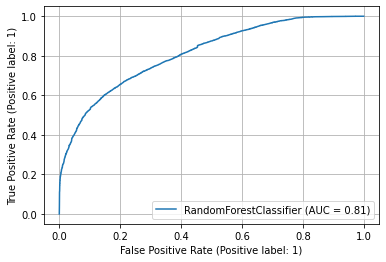

Confusion matrix


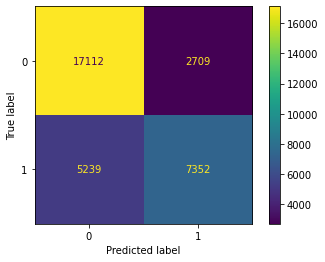

Classification report
              precision    recall  f1-score   support

           0       0.77      0.86      0.81     19821
           1       0.73      0.58      0.65     12591

    accuracy                           0.75     32412
   macro avg       0.75      0.72      0.73     32412
weighted avg       0.75      0.75      0.75     32412

Feature importance table and graph


,features,importance
0,arrival_date_month,0.000186
1,arrival_date_week_number,0.000796
2,arrival_date_day_of_month,0.002867
3,stays_in_weekend_nights,0.005045
4,stays_in_week_nights,0.005177
5,adults,0.006611
6,children,0.007550
7,babies,0.009997
8,meal,0.010881
9,country_0,0.013899


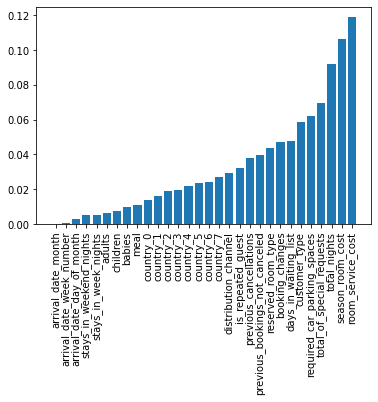

In [ ]:
testing_model(max_depth_=15,
              n_estimators_=146,
              criterion_='gini',
              ftrain =features_upsampled_train,
              ftest =features_test,
              ttrain =target_upsampled_train,
              ttest =target_test)


In [ ]:
hotel_test.columns

Index(['id', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country_0', 'country_1', 'country_2', 'country_3', 'country_4',
       'country_5', 'country_6', 'country_7', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'days_in_waiting_list', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_nights', 'norm_room_cost', 'season_room_cost',
       'number_of_cleaning', 'room_service_cost', 'total_revenue'],
      dtype='object')

In [ ]:
def mean_cancellation_by(data,columnby):
    return data.groupby(columnby).agg({'is_canceled':'mean'}).sort_values(by='is_canceled')

In [ ]:
mean_cancellation_by(hotel_test,'room_service_cost')

,is_canceled
room_service_cost,
150,0.346748
400,0.402838
350,0.437659


In [ ]:
mean_cancellation_by(hotel_test,'season_room_cost')

,is_canceled
season_room_cost,
500.0,0.215947
350.0,0.275862
800.0,0.294118
450.0,0.294479
540.0,0.324468
550.0,0.335106
600.0,0.337209
1120.0,0.337349
1000.0,0.339237


In [ ]:
mean_cancellation_by(hotel_test,'total_nights')

,is_canceled
total_nights,
1,0.250686
9,0.290323
10,0.345455
7,0.366025
6,0.378062
5,0.383147
4,0.390528
8,0.418605
2,0.423817


In [ ]:
mean_cancellation_by(hotel_test,'total_of_special_requests')

,is_canceled
total_of_special_requests,
5,0.055556
4,0.104839
3,0.171996
2,0.262287
1,0.278968
0,0.494578


In [ ]:
mean_cancellation_by(hotel_test,'required_car_parking_spaces')

,is_canceled
required_car_parking_spaces,
1,0.000000
2,0.000000
3,0.000000
8,0.000000
0,0.407015


In [ ]:
mean_cancellation_by(hotel_test,'customer_type')

,is_canceled
customer_type,
3,0.048485
1,0.125348
2,0.165575
0,0.429882


In [ ]:
mean_cancellation_by(hotel_test,'booking_changes')

,is_canceled
booking_changes,
7,0.000000
8,0.000000
10,0.000000
11,0.000000
14,0.000000
15,0.000000
16,0.000000
18,0.000000
1,0.130179


In [ ]:
mean_cancellation_by(hotel_test,'reserved_room_type')

,is_canceled
reserved_room_type,
1,0.326044
2,0.336375
3,0.348195
6,0.402838
0,0.413669
5,0.432292
4,0.442786


In [ ]:
reserved_room_type_train

{'G': 0, 'F': 1, 'E': 2, 'D': 3, 'C': 4, 'B': 5, 'A': 6}

In [ ]:
mean_cancellation_by(hotel_test,'previous_cancellations')

,is_canceled
previous_cancellations,
5,0.000000
6,0.000000
2,0.137931
1,0.157576
4,0.300000
3,0.333333
0,0.390108


In [ ]:
mean_cancellation_by(hotel_test,'previous_bookings_not_canceled')

,is_canceled
previous_bookings_not_canceled,
22,0.000000
24,0.000000
25,0.000000
27,0.000000
28,0.000000
29,0.000000
30,0.000000
58,0.000000
59,0.000000


In [ ]:
mean_cancellation_by(hotel_test,'is_repeated_guest')

,is_canceled
is_repeated_guest,
1,0.048181
0,0.399490


In [ ]:
mean_cancellation_by(hotel_test,'distribution_channel')

,is_canceled
distribution_channel,
3,0.164706
0,0.171060
2,0.255930
1,0.426245


In [ ]:
distribution_channel_dct_train

{'Direct': 0, 'TA/TO': 1, 'Corporate': 2, 'GDS': 3}

In [ ]:
mean_cancellation_by(hotel_test,'meal')

,is_canceled
meal,
2,0.332222
3,0.385604
1,0.388889
0,0.394547


In [ ]:
meal_dct_train

{'BB': 0, 'FB': 1, 'HB': 2, 'SC': 3}

In [ ]:
mean_cancellation_by(hotel_test,'customer_type')

,is_canceled
customer_type,
3,0.048485
1,0.125348
2,0.165575
0,0.429882


In [ ]:
customer_type_train

{'Transient': 0, 'Contract': 1, 'Transient-Party': 2, 'Group': 3}

In [ ]:
model = RandomForestClassifier(max_depth=15,n_estimators=150,criterion='entropy')
model.fit(features_upsampled_train,target_upsampled_train)

RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=150)

In [ ]:
print(classification_report(target_test,model.predict(features_test)))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81     19821
           1       0.73      0.59      0.65     12591

    accuracy                           0.76     32412
   macro avg       0.75      0.73      0.73     32412
weighted avg       0.75      0.76      0.75     32412



In [ ]:
metrics_check(target_test,model.predict(features_test))

Accuracy для тестовой выборки: 0.7567567567567568
----------------------------------------------------------------------------------------------------
Balanced accuracy для тестовой выборки: 0.7265215842861036
----------------------------------------------------------------------------------------------------
F1-score для тестовой выборки: 0.6536941052446631
----------------------------------------------------------------------------------------------------
Precision score для тестовой выборки: 0.7313022113022113
----------------------------------------------------------------------------------------------------
Recall score для тестовой выборки: 0.5909776824716068
----------------------------------------------------------------------------------------------------
F-beta score для тестовой выборки: 0.6536941052446631
----------------------------------------------------------------------------------------------------


In [ ]:
hotel_test_profit_wo_model

26061570.0

In [ ]:
hotel_test.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,norm_room_cost,season_room_cost,number_of_cleaning,room_service_cost,total_revenue
0,6086,1,74,2017,0,1,1,1,0,2,...,0,0,0,0,1,1000,1000.0,0,400,-1400.0
1,6087,1,62,2017,0,1,1,2,2,2,...,0,0,0,1,4,1000,1000.0,0,400,-1400.0
2,6088,1,62,2017,0,1,1,2,2,2,...,0,0,0,1,4,1000,1000.0,0,400,-1400.0
3,6089,1,71,2017,0,1,1,2,2,1,...,0,0,0,1,4,1000,1000.0,0,400,-1400.0
4,6090,1,172,2017,0,1,1,2,5,2,...,0,0,0,0,7,1000,1000.0,0,400,-1400.0


In [ ]:
model.predict(features_test)

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
hotel_test['model_predict'] = model.predict(features_test)

In [ ]:
hotel_test['deposit'] = np.where((hotel_test['model_predict'] == 1) & (hotel_test['is_canceled'] ==1),(hotel_test['season_room_cost'] + hotel_test['room_service_cost'])*0.8,0)

In [ ]:
hotel_test['is_canceled'].sum()

12591

In [ ]:
hotel_test['model_predict'].sum()

10175

In [ ]:
hotel_test[(hotel_test['model_predict'] == 1) &  (hotel_test['is_canceled'] == 1)]

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,required_car_parking_spaces,total_of_special_requests,total_nights,norm_room_cost,season_room_cost,number_of_cleaning,room_service_cost,total_revenue,model_predict,deposit
16,6103,1,44,2017,0,1,3,2,5,2,...,0,0,7,1000,1000.0,0,400,-1400.0,1,1120.0
22,6109,1,112,2017,0,1,4,2,4,2,...,0,2,6,550,550.0,0,150,-700.0,1,560.0
55,6142,1,87,2017,0,2,14,2,1,2,...,0,0,3,1000,1000.0,0,400,-1400.0,1,1120.0
57,6144,1,45,2017,0,2,14,2,5,2,...,0,1,7,1000,1000.0,0,400,-1400.0,1,1120.0
58,6146,1,40,2017,0,3,16,1,2,1,...,0,0,3,1000,1000.0,0,400,-1400.0,1,1120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18286,69949,1,8,2017,5,24,17,2,2,1,...,0,0,4,550,770.0,0,150,-920.0,1,736.0
18301,70397,1,194,2017,4,21,25,0,3,2,...,0,0,3,550,660.0,0,150,-810.0,1,648.0
22347,87839,1,13,2017,4,22,29,1,2,1,...,0,0,3,1000,1200.0,0,400,-1600.0,1,1280.0
22350,87842,1,13,2017,4,22,29,1,2,1,...,0,0,3,1000,1200.0,0,400,-1600.0,1,1280.0


In [ ]:
def profit_w_model(data):
    return profit(data) + data.query('model_predict == 1 & is_canceled == 1')['deposit'].sum()

In [ ]:
profit_w_model(hotel_test)

34811922.0

In [ ]:
features_test.head()

,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country_0,...,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,season_room_cost,room_service_cost
0,0,1,1,1,0,2,0,0,0,0,...,0,6,0,0,0,0,0,1,1000.0,400
1,0,1,1,2,2,2,0,0,0,0,...,0,6,0,0,0,0,1,4,1000.0,400
2,0,1,1,2,2,2,0,0,0,0,...,0,6,0,0,0,0,1,4,1000.0,400
3,0,1,1,2,2,1,0,0,0,0,...,0,6,0,0,0,0,1,4,1000.0,400
4,0,1,1,2,5,2,0,0,0,0,...,0,6,0,0,0,0,0,7,1000.0,400


In [ ]:
target_test

0        1
1        1
2        1
3        1
4        1
        ..
32407    0
32408    0
32409    0
32410    0
32411    0
Name: is_canceled, Length: 32412, dtype: int64

In [ ]:
hotel_test.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,required_car_parking_spaces,total_of_special_requests,total_nights,norm_room_cost,season_room_cost,number_of_cleaning,room_service_cost,total_revenue,model_predict,deposit
0,6086,1,74,2017,0,1,1,1,0,2,...,0,0,1,1000,1000.0,0,400,-1400.0,0,0.0
1,6087,1,62,2017,0,1,1,2,2,2,...,0,1,4,1000,1000.0,0,400,-1400.0,0,0.0
2,6088,1,62,2017,0,1,1,2,2,2,...,0,1,4,1000,1000.0,0,400,-1400.0,0,0.0
3,6089,1,71,2017,0,1,1,2,2,1,...,0,1,4,1000,1000.0,0,400,-1400.0,0,0.0
4,6090,1,172,2017,0,1,1,2,5,2,...,0,0,7,1000,1000.0,0,400,-1400.0,0,0.0


In [ ]:
# Создадим объект класса с балнсировкой класса
model_lr = LogisticRegression(class_weight='balanced', random_state=rs)



In [ ]:
# Создадим список параметров для перебора (коэффициент регуляризации)
parameters_lr = {'C': np.linspace(0.1, 10, 10), 'penalty' : ['l1', 'l2', 'elasticnet', 'none']}



In [ ]:
# Создаем модель для каждого из возможных параметров с использованием кросс-валидации на 8 частей
grid_search_clf_lr = GridSearchCV(
    model_lr, parameters_lr,  scoring='f1', n_jobs=-1, cv=3, verbose=10)


In [ ]:
# Выявляем лучшие параметры
grid_search_clf_lr.fit(features_upsampled_train, target_upsampled_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV 1/3; 1/40] START C=0.1, penalty=l1..........................................
[CV 1/3; 1/40] END ........................C=0.1, penalty=l1; total time=   0.0s
[CV 2/3; 1/40] START C=0.1, penalty=l1..........................................
[CV 2/3; 1/40] END ........................C=0.1, penalty=l1; total time=   0.0s
[CV 3/3; 1/40] START C=0.1, penalty=l1..........................................
[CV 3/3; 1/40] END ........................C=0.1, penalty=l1; total time=   0.0s
[CV 1/3; 2/40] START C=0.1, penalty=l2..........................................
[CV 1/3; 2/40] END ........................C=0.1, penalty=l2; total time=   4.9s
[CV 2/3; 2/40] START C=0.1, penalty=l2..........................................
[CV 2/3; 2/40] END ........................C=0.1, penalty=l2; total time=   5.2s
[CV 3/3; 2/40] START C=0.1, penalty=l2..........................................
[CV 3/3; 2/40] END ........................C=0.

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=7),
             n_jobs=-1,
             param_grid={'C': array([ 0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ]),
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             scoring='f1', verbose=10)

In [ ]:
# Смотрим что получилось
grid_search_clf_lr.best_params_

{'C': 4.5, 'penalty': 'l2'}

In [ ]:
# Лучшая оценка на кросс-валидации
grid_search_clf_lr.best_score_

0.7542875935808318

In [ ]:
model_dt = DecisionTreeClassifier(class_weight='balanced', random_state=rs)
# Создадим список параметров для перебора (критерий и глубина дерева)





In [ ]:
parameters_dt = {'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': range(
    1, 15), 'min_impurity_decrease': np.arange(0.0, 0.01, 0.001)}

In [ ]:
# Создаем модель для каждого из возможных параметров
grid_search_clf_dt = GridSearchCV(
    model_dt, parameters_dt, scoring='f1', n_jobs=-1, cv=3, verbose=10)

In [ ]:
# Выявляем лучшие параметры
grid_search_clf_dt.fit(features_upsampled_train, target_upsampled_train)

Fitting 3 folds for each of 420 candidates, totalling 1260 fits
[CV 1/3; 1/420] START criterion=gini, max_depth=1, min_impurity_decrease=0.0....
[CV 1/3; 1/420] END criterion=gini, max_depth=1, min_impurity_decrease=0.0; total time=   0.1s
[CV 2/3; 1/420] START criterion=gini, max_depth=1, min_impurity_decrease=0.0....
[CV 2/3; 1/420] END criterion=gini, max_depth=1, min_impurity_decrease=0.0; total time=   0.1s
[CV 3/3; 1/420] START criterion=gini, max_depth=1, min_impurity_decrease=0.0....
[CV 3/3; 1/420] END criterion=gini, max_depth=1, min_impurity_decrease=0.0; total time=   0.1s
[CV 1/3; 2/420] START criterion=gini, max_depth=1, min_impurity_decrease=0.001..
[CV 1/3; 2/420] END criterion=gini, max_depth=1, min_impurity_decrease=0.001; total time=   0.1s
[CV 2/3; 2/420] START criterion=gini, max_depth=1, min_impurity_decrease=0.001..
[CV 2/3; 2/420] END criterion=gini, max_depth=1, min_impurity_decrease=0.001; total time=   0.1s
[CV 3/3; 2/420] START criterion=gini, max_depth=1, m

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=7),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(1, 15),
                         'min_impurity_decrease': array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009])},
             scoring='f1', verbose=10)

In [ ]:
# Смотрим что получилось
grid_search_clf_dt.best_params_

{'criterion': 'gini', 'max_depth': 14, 'min_impurity_decrease': 0.0}

In [ ]:
# Лучшая оценка на кросс-валидации
grid_search_clf_dt.best_score_


0.8356548708076511

In [ ]:
# Создадим объект класса
model_rf = RandomForestClassifier(class_weight='balanced', random_state=rs)
# Создадим список параметров для перебора (критерий и глубина дерева)
parameters_rf = {'criterion': ['gini', 'entropy'], 'max_depth': range(
    1, 15), 'n_estimators': np.arange(50, 150, 10)}



In [ ]:
# Создаем модель для каждого из возможных параметров
grid_search_clf_dt = GridSearchCV(
    model_rf, parameters_rf, scoring='f1', n_jobs=-1, cv=3, verbose=10)

In [ ]:
# Выявляем лучшие параметры
grid_search_clf_dt.fit(features_upsampled_train, target_upsampled_train)



Fitting 3 folds for each of 280 candidates, totalling 840 fits
[CV 1/3; 1/280] START criterion=gini, max_depth=1, n_estimators=50..............
[CV 1/3; 1/280] END criterion=gini, max_depth=1, n_estimators=50; total time=   0.5s
[CV 2/3; 1/280] START criterion=gini, max_depth=1, n_estimators=50..............
[CV 2/3; 1/280] END criterion=gini, max_depth=1, n_estimators=50; total time=   0.5s
[CV 3/3; 1/280] START criterion=gini, max_depth=1, n_estimators=50..............
[CV 3/3; 1/280] END criterion=gini, max_depth=1, n_estimators=50; total time=   0.5s
[CV 1/3; 2/280] START criterion=gini, max_depth=1, n_estimators=60..............
[CV 1/3; 2/280] END criterion=gini, max_depth=1, n_estimators=60; total time=   0.6s
[CV 2/3; 2/280] START criterion=gini, max_depth=1, n_estimators=60..............
[CV 2/3; 2/280] END criterion=gini, max_depth=1, n_estimators=60; total time=   0.6s
[CV 3/3; 2/280] START criterion=gini, max_depth=1, n_estimators=60..............
[CV 3/3; 2/280] END criter

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=7),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 15),
                         'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140])},
             scoring='f1', verbose=10)

In [ ]:
# Смотрим что получилось
grid_search_clf_dt.best_params_

{'criterion': 'gini', 'max_depth': 14, 'n_estimators': 140}

In [ ]:
# Лучшая оценка на кросс-валидации
grid_search_clf_dt.best_score_

0.849100307186523

In [ ]:
model = RandomForestClassifier(max_depth=14,n_estimators=140,criterion='gini')
model.fit(features_upsampled_train,target_upsampled_train)

RandomForestClassifier(max_depth=14, n_estimators=140)

In [ ]:
metrics_check(target_test,model.predict(features_test))

Accuracy для тестовой выборки: 0.7578057509564359
----------------------------------------------------------------------------------------------------
Balanced accuracy для тестовой выборки: 0.7270171321389337
----------------------------------------------------------------------------------------------------
F1-score для тестовой выборки: 0.6539105898950711
----------------------------------------------------------------------------------------------------
Precision score для тестовой выборки: 0.7349122980874047
----------------------------------------------------------------------------------------------------
Recall score для тестовой выборки: 0.5889921372408864
----------------------------------------------------------------------------------------------------
F-beta score для тестовой выборки: 0.6539105898950711
----------------------------------------------------------------------------------------------------


ROC-AUC-curve and ROC-AUC-score


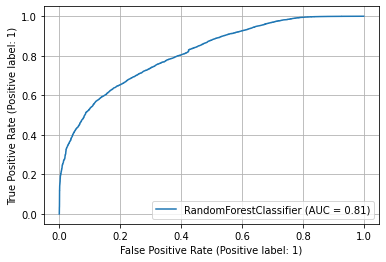

Confusion matrix


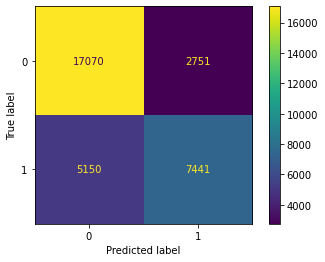

Classification report
              precision    recall  f1-score   support

           0       0.77      0.86      0.81     19821
           1       0.73      0.59      0.65     12591

    accuracy                           0.76     32412
   macro avg       0.75      0.73      0.73     32412
weighted avg       0.75      0.76      0.75     32412

Feature importance table and graph


,features,importance
0,arrival_date_month,0.000180
1,arrival_date_week_number,0.000578
2,arrival_date_day_of_month,0.002940
3,stays_in_weekend_nights,0.004549
4,stays_in_week_nights,0.006147
5,adults,0.006512
6,children,0.006884
7,babies,0.009972
8,meal,0.010270
9,country_0,0.011930


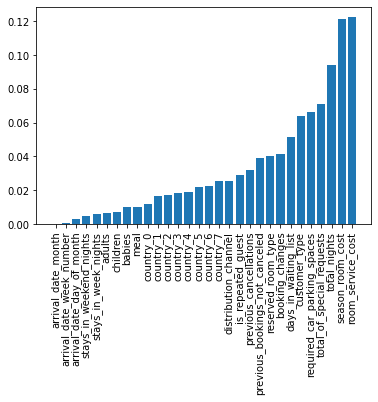

In [ ]:
testing_model(max_depth_=14,
              n_estimators_=140,
              criterion_='gini',
              ftrain =features_upsampled_train,
              ftest =features_test,
              ttrain =target_upsampled_train,
              ttest =target_test)


**Вывод по всем моделям**

Как мы выдим, линейная модель показывает себя намного хуже, чем семейство деревеьв. Одно дерево решений несильно уступает, но все-таки уступает по метрики кросс валдации случайному лесу. Поэтому выбираем случайный лес, он, очевидно, лучше этих двух моделей:

Значение кросс валидации по убыванию:

1. **Случайный лес - 0.849100307186523**
2. **Дерево решений - 0.8356548708076511**
3. **Логистрическая регрессия - 0.7542875935808318**


## Общий вывод

**Выводы:**

---
Лучшая модель - это случайный лес с upsampling, показывает на кросс-валидации средний результат равный **0.844096226111763**.

-----
Следущие параметры леса:

* max_depth=14
* n_estimators=140
* criterion='gini'
------
Метрика для оценки качесва:

* F1-score для тестовой выборки: **0.6513261900579659** достаточно хороший показатель

Precision и recall для `0` и для `1` соответсвенно:

* Precision = **0.77**     

* Recall =  **0.86**
Для `0` - достаточно хорошие показатели по обеим метрикам

* Precision =  **0.73**      

* Recall = **0.59**

Для `1` - достаточно хороший показатель по точности и средний показатель по полноте.

-----------
Рекомендации и вообще валидация и поиск модели должна исходить из того, что скажет бизнес - ему важнее точно находить всех отказников и не попадать на хороших, или забить на хороших и ловить всех отказников включая хороший, но зато со всей полнотой.

--------------
Я бы дал такую рекомендацию:

Если человек действительно хочет приехать в отель, то он сделает это в любом случае, за исключением форс мажорных обстоятельств, которые человек должен документально подтвердить - в этом случае депозит  возвращается полностью или какой-то процент, в зависимости от тяжести обстоятельств - прописать это в договоре. Поэтому стоит выбрать тактику с точностью. Депозит будет отсеивать, это как тестовое задание на разных сайтах по поиску вакансий, работы и т.д. Дополнительный барьер способен отсеить лвьиную долю отказников.

--------
Портрет наиболее вероятного отказника:

* Цена за уборку: 350 V 400
* Цена за номер (сезонная): 490 V 960 V 720 V 840
* Всего ночей: 8 V 2 V 3
* Количество специальных отметок: 0
* Нужно парковочных мест: 0
* Тип клиента: Transient — не связано с договором или групповым заездом
* Количество изменений параметров заказа: 6 V 0
* Тип номера(номанильная стоимость + обслуживание): A (1_000 + 400) V G (350 + 150) V B (800 + 350) V C (600 + 350)
* Раньше отменяли заказ: 0
* Раньше отменяли заказ на booking: 0
* Повтоный гость: 0
* Канал дистрибуции заказа: TA/TO V Corporate
* Завтрак: FB(включён завтрак, обед и ужин) V BB(включён завтрак) V SC(нет дополнительных опций)

----

Прибыль до внедрения модели:

68_433_270 рублей

Прибыль после внедрения модели:

77_160_310



Рост составляет 12.752627% или 8_727_040 рублей. Что является каким ни каким показателем.

